# SV-RCNet

In [2]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler, BatchSampler
from torchvision import models, transforms
from torch import nn, optim

from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.clean_labels import clean_labels
from utils.mydataset import SVRCDataset

import os
from datetime import datetime
import random
import time

%load_ext autoreload
%autoreload 2

## Data Preprocessing

### Extract frames

In [6]:
# put videos here!
#video_base = 'D:/e6691/6691_assignment2/videos'
video_base = 'data/videos'
videos = [v for v in os.listdir(video_base) if v.endswith('mp4')]
# images will be output to here'
print(videos)
#image_base = 'D:/e6691/6691_assignment2/images'
image_base = 'data/images'
if not os.path.exists(image_base):
    os.mkdir(image_base)

['RALIHR_surgeon01_fps01_0071.mp4', 'RALIHR_surgeon01_fps01_0002.mp4', 'RALIHR_surgeon01_fps01_0001.mp4']


In [ ]:
# command line: 
# ffmpeg -i {input_video} -r {frame_rate} [-f {force_format} (not needed)] {output_images}
# doc: https://ffmpeg.org/ffmpeg.html
for video in videos:
    input_path = os.path.join(video_base, video)
    # make dirs
    output_base = image_base + '/{}'.format(video.split('.')[0])
    if not os.path.exists(output_base):
        os.mkdir(output_base)
    output_path = os.path.join(output_base, '%d.png')
    # command
    print('Frames extracted from {} to {}'.format(input_path, output_path))
    #!ffmpeg -i {input_path} -r 1 {output_path}

### Extract labels

In [18]:
# some useless rows are manually deleted
# labels_path = 'D:/e6691/6691_assignment2'
labels_path = 'data/labels/video.phase.trainingData.clean.StudentVersion.csv'
# names_path = 'D:/e6691/6691_assignment2'
names_path = 'data/labels/all_labels_hernia.csv'

# this is already a cleaned file
labels_df = pd.read_csv(labels_path)
names_df = pd.read_csv(names_path, names=['Name'])

In [29]:
# clean
labels_df_cleaned = clean_labels(labels_df, names_df)
labels_df_cleaned.to_csv('data/labels/phase_trainingData_clean.csv')
# drop 'access' and 'acquiring suture'
#names_df_cleaned = names_df.iloc[2:].reset_index(drop=True)

In [ ]:
# convert time string to int
# start time
t0 = datetime(1900, 1, 1)
def time2int(t):
    # if convertable
    return (
        # time given in MM:SS
        datetime.strptime(t, '%M:%S') - t0
    ).seconds if len(t.split(':')) == 2 else (
        # time given in HH:MM:SS
        datetime.strptime(t, '%H:%M:%S') - t0
    ).seconds

# extract names
for video in videos:
    images = os.listdir(os.path.join(image_base, video.split('.')[0]))
    # get df corresponding to current video
    video_df = labels_df_cleaned.loc[labels_df_cleaned['videoName'] == video.split('.')[0]]
    # add two columns
    video_df[['StartSec', 'EndSec']] = video_df[['Start', 'End']].applymap(time2int)
    # 这warning好烦但我懒得改了
    for image in images:
        # check paths
        base = os.path.join(image_base, video.split('.')[0])
        path = os.path.join(base, image)
        # if '-' in image:
        #     continue
        t = int(image.split('.')[0].split('-')[0])
        # select interval and remove tailing digits
        name = video_df[
            (video_df['StartSec'] <= t) & (t <= video_df['EndSec'])
        ]['PhaseNameClean'].iloc[0]
        # find correct integer labels
        label = names_df[names_df['Name'] == name].index[0]
        # incorperate label into filenames
        if '-' not in path:
            # avoid renaming twice
            #new_path = ''.join(path.split('.')[:-1]) + '-{}.'.format(label) + path.split('.')[-1]
            new_path = '{}-{}.{}'.format(''.join(path.split('.')[:-1]), label, path.split('.')[-1])
        else:
            #new_path = path.split('-')[0] + '-' + str(label) + '.' + path.split('-')[1].split('.')[1]
            new_path = '{}-{}.{}'.format(path.split('-')[0], label, path.split('-')[1].split('.')[1])
        # rename all files
        os.rename(path, new_path)

## Dataset Construction

In [3]:
# Data properties
num_labels = 14

In [ ]:
# get all images and labels
image_paths = []
labels = []

for video in sorted(videos)[:1]:
    base = os.path.join(image_base, video.split('.')[0])
    image_paths.append(list(map(
        lambda img: base + '/' + img if img.endswith('.png') else None, 
        os.listdir(base)
    )))


image_paths = [list(filter(None, images)) for images in image_paths]
#image_paths = [list(sorted(images, key=sort_images)) for images in image_paths]

labels = [
    [int(img.split('.')[0].split('-')[1]) for img in images]
    for images in image_paths
]
list(zip(image_paths[0], labels[0]))

In [44]:
# define transforms
data_transform = {
    'train': transforms.Compose([
        #transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(size=(32,32), scale=(0.4,1.0), ratio=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]), 
    'valid': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}

In [45]:
# get training set
train_set = SVRCDataset(
    image_paths[0], 
    labels[0], 
    data_transform['train']
)

In [46]:
# get dataloader
train_loader = DataLoader(train_set, batch_size = 8, shuffle = True, num_workers = 0)

In [50]:
n = next(iter(train_loader))
X = n['feature']
y = n['label']

## Data Visualization

In [51]:
# fishnet曹老师的代码
def plot(x,y):
    """
    Plot random images for verification
    """

    fig = plt.figure(figsize=(16,8))
    plt.subplots_adjust(top=1.2)
    col = 4
    row = 2
    print(str(col*row)+" Random images and their labels")
    ri = random.sample(range(0,len(x)),col*row)
    rii = 0
    for i in range(1, col*row+1):
        img = np.copy(x[ri[rii]])
        img = np.asarray(img, dtype=np.float32)
        fig.add_subplot(row,col,i)
        x_label = 'Label : ' + str(y[ri[rii]])
        plt.xlabel(x_label)
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        # shift for pytorch
        plt.imshow(np.moveaxis(img, 0, -1), interpolation = 'nearest')
        rii = rii + 1
    _ = plt.show()

8 Random images and their labels


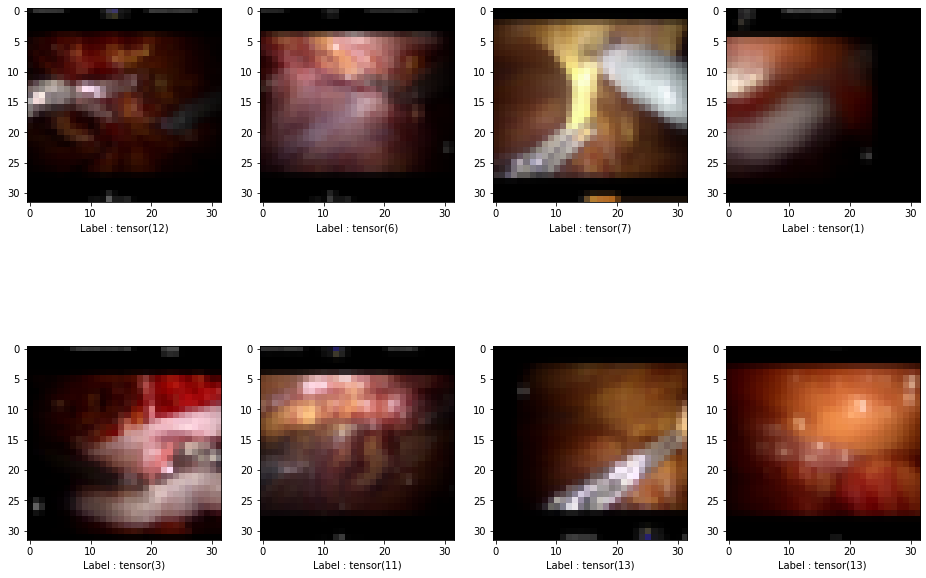

In [52]:
plot(X, y)

## class SVRCDataset

In [57]:
class SVRCDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform = None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item): #can add more rules to pick data
        img = Image.open(self.image_path[item])
        label = self.image_class[item]
        if self.transform is not None:
            img = self.transform(img)

        return {'feature': img, 'label': label}

class MyDataset(Dataset):
    def __init__(self, labels, features):
        super(MyDataset, self).__init__()
        self.labels = labels
        self.features = features
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx: int):
        feature = self.features[idx]
        label = self.labels[idx]
        return {'feature': feature, 'label': label}

## class Train

In [23]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

class Train(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()
        self.shuffle = True
    
    def train(self, labels, features, transform):
        self.model.train()
        dataset = SVRCDataset(features, labels, transform)
        loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        for epoch in range(EPOCHS):
            train_loss = 0.0
            train_acc = 0
            for i, data in enumerate(loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(dataset)
            train_acc /= len(dataset)
            if epoch==0 or (epoch+1)%1==0:
                print('Epoch[{}/{}] loss:{:.3} | acc:{:.4}'.format(epoch+1, EPOCHS, train_loss, train_acc))

In [ ]:
dataset = SVRCDataset(image_paths, labels, data_transform['train'])
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
next(iter(loader))

In [17]:
print(len(set(labels)))

11


## class CNN

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,6,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Sequential(nn.Linear(16*8*8, 512), nn.ReLU(),)
        self.fc2 = nn.Sequential(nn.Linear(512, 128), nn.ReLU(),)
        self.out = nn.Linear(128,num_labels)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

    def predict(self, features):
        self.eval()
        features = torch.from_numpy(features).float()
        labels = self.forward(features).detach().numpy()
        labels = np.argmax(labels, axis=1)
        return labels

## CNN results

In [ ]:
# Weights path
WeightsPath = './models/weights'

# Data Preprocessing

#N,C,H,W = 10, 3, 224, 224
#X = np.zeros((N,C,H,W))
#y = np.zeros((N,))
X = image_paths
y = labels
#model = ResNet()
model = CNN()
print(model)
start_time = time.time()

trainer = Train(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

torch.save(model.state_dict(),WeightsPath)

#model = SVRC()
#model.load_state_dict(torch.load(WeightsPath))

## resnet18 results

In [ ]:
# Data
X = image_paths
y = labels
model = models.resnet18()
model.fc = nn.Linear(512,num_labels)
print(model)
start_time = time.time()

trainer = Train(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

In [30]:
len(dataset)

4470

## Validation

In [58]:
# train-val
train = SVRCDataset(image_paths[:4000], labels[:4000], data_transform['train'])
test = SVRCDataset(image_paths[4000:], labels[4000:], data_transform['train'])
train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)
#next(iter(train_loader))

In [ ]:
next(iter(train_loader))

## class TrainVal

In [70]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

class TrainVal(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()
        self.shuffle = True

    def train(self, labels, features, transform):
        self.model.train()
        dataset = SVRCDataset(image_paths, labels, transform)
        train, test = random_split(dataset, [4000,470])
        train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        for epoch in range(EPOCHS):
            train_loss = 0.0
            train_acc = 0.0
            for i, data in enumerate(train_loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(train)
            train_acc /= len(train)

            valid_loss = 0.0
            valid_acc = 0.0
            total = 0
            self.model.eval()
            for i, data in enumerate(test_loader):
                features = data['feature']
                labels = data['label']
                
                predictions = self.model(features)
                loss = self.criterion(predictions,labels)
                valid_loss += loss.item()
                
                preds = torch.max(predictions.data, 1)[1]
                valid_acc += (preds==labels).sum().item()
                total += features.size(0)
            
            valid_loss /= len(test)
            valid_acc /= len(test)
            
            print(
                f'Epoch {epoch+1} Training Loss: {train_loss} Validation Loss: {valid_loss} || '
                f'Train_acc: {train_acc} Valid_acc: {valid_acc}'
            )    

## Validation results

In [ ]:
# Data
X = image_paths
y = labels
# Model
model = models.resnet18()
model.fc = nn.Linear(512,num_labels)
print(model)

start_time = time.time()

trainer = TrainVal(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

## Pretrain
### Pretarin the resnet18 (pretrained on imagenet) on our datset.

In [ ]:
# Weights path
WeightsPath = './models/weights'

# Data
X = image_paths
y = labels
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512,num_labels)
trainer = Train(model)
trainer.train(y, X, data_transform['train'])

torch.save(model.state_dict(),WeightsPath)

## class SVRCNet

In [73]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 30
EPOCHS = 10

In [62]:
class SVRC(nn.Module):
    def __init__(self):
        super(SVRC,self).__init__()
        # ResNet-18
        self.resnet18 = nn.Sequential(*(
            list(
                models.resnet18(pretrained=True).children()
            )[:-1]
        ))
        #self.resnet18.eval()
        self.pretrain = True
        # LSTM
        self.lstm = nn.LSTM(512,512)
        self.lstm_states = None
        # FC
        self.full = nn.Linear(512,num_labels)

    def forward(self,x):
        x = self.resnet18(x)
        # Reshape
        #print(x.shape)
        if not self.pretrain:
            x = x.view(3,10,-1) # time step, batch size
            x,s = self.lstm(x, self.lstm_states)
            # save lstm states
            self.lstm_states = (s[0].detach(), s[1].detach())
        x = self.full(x.view(-1,512))
        return x #if self.pretrain else nn.Softmax(1)(x).view(30,-1)

## Load weights and train SVRCNet

In [70]:
class SVRCDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform = None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item): #can add more rules to pick data
        img = Image.open(self.image_path[item])
        label = self.image_class[item]
        if self.transform is not None:
            img = self.transform(img)

        return {'feature': img, 'label': label}

In [43]:
def sort_images(x):
    vid = int(x[0].split('_')[-1].split('/')[0])
    frame = int(x[0].split('/')[-1].split('-')[0])
    return vid*7200 + frame

In [44]:
image_paths_lstm = []
labels_lstm = []
for path,label in sorted(zip(image_paths, labels), key=sort_images):
    image_paths_lstm.append(path)
    labels_lstm.append(label)

In [ ]:
sorted(zip(image_paths, labels), key=sort_images)

In [81]:
#next(iter(train_loader))
train = SVRCDataset(image_paths_lstm[:1500], labels_lstm[:1500], data_transform['train'])
test = SVRCDataset(image_paths_lstm[1500:], labels_lstm[1500:], data_transform['train'])
train_loader = DataLoader(
    train, batch_sampler=BatchSampler(
        RandomSampler(train) if False else SequentialSampler(train), 
        BATCH_SIZE, 
        drop_last=True
    )
)
test_loader = DataLoader(
    test, batch_sampler=BatchSampler(
        RandomSampler(test) if False else SequentialSampler(test), 
        BATCH_SIZE, 
        drop_last=True
    )
)

In [82]:
train_loader

In [ ]:
for i,b in enumerate(train_loader):
    print(b['label'])

In [46]:
len(image_paths)

1967

In [106]:
# Training parameters LSTM
LR = 1e-3
BATCH_SIZE = 30
EPOCHS = 5
TRAIN_SIZE = int(0.7 * len(image_paths))

class SVRCDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform = None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item): #can add more rules to pick data
        img = Image.open(self.image_path[item])
        label = self.image_class[item]
        if self.transform is not None:
            img = self.transform(img)

        return {'feature': img, 'label': label}

class TrainVal(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, labels, features, transform, eval_intval=5):
        # if self.model.pretrain:
        #     self.model.train()
        #     train = SVRCDataset(image_paths[:TRAIN_SIZE], labels[:TRAIN_SIZE], transform)
        #     test = SVRCDataset(image_paths[TRAIN_SIZE:], labels[TRAIN_SIZE:], transform)
        #     train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
        #     test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

        # else:
        #     self.model.lstm.train()
        #     self.model.full.train()
        #     train = SVRCDataset(image_paths_lstm[:TRAIN_SIZE], labels_lstm[:TRAIN_SIZE], transform)
        #     test = SVRCDataset(image_paths_lstm[TRAIN_SIZE:], labels_lstm[TRAIN_SIZE:], transform)
        #     train_loader = DataLoader(
        #         train, 
        #         batch_sampler=BatchSampler(SequentialSampler(train), BATCH_SIZE, drop_last=True), 
        #         shuffle = False
        #     )
        #     test_loader = DataLoader(
        #         test, 
        #         batch_sampler=BatchSampler(SequentialSampler(test), BATCH_SIZE, drop_last=True), 
        #         shuffle = False
        #     )
        train = SVRCDataset(features[:TRAIN_SIZE], labels[:TRAIN_SIZE], transform)
        test = SVRCDataset(features[TRAIN_SIZE:], labels[TRAIN_SIZE:], transform)
        train_loader = DataLoader(
            train, batch_sampler=BatchSampler(
                RandomSampler(train) if self.model.pretrain else SequentialSampler(train), 
                BATCH_SIZE, 
                drop_last=True
            )
        )
        test_loader = DataLoader(
            test, batch_sampler=BatchSampler(
                RandomSampler(test) if self.model.pretrain else SequentialSampler(test), 
                BATCH_SIZE, 
                drop_last=True
            )
        )

        for epoch in range(EPOCHS):
            lstm_eval = ~self.model.pretrain and (epoch + 1) % eval_intval == 0

            if self.model.pretrain:
                self.model.train()
            elif not lstm_eval:
                self.model.lstm.train()
                self.model.full.train()
            else:
                self.model.eval()

            train_loss = 0.0
            train_acc = 0.0

            for i, data in enumerate(train_loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(train)
            train_acc /= len(train)

            if self.model.pretrain:
                print(f'Epoch {epoch+1} Training Loss: {train_loss} Train_acc: {train_acc}', end=' ')
            else:
                phase = 'Valid' if lstm_eval else 'Train'
                print(f'Epoch {epoch+1} - {phase} Loss: {train_loss} Acc: {train_acc}')

            if self.model.pretrain:
                valid_loss = 0.0
                valid_acc = 0.0
                total = 0
                self.model.eval()
                for i, data in enumerate(test_loader):
                    features = data['feature']
                    labels = data['label']

                    predictions = self.model(features)
                    loss = self.criterion(predictions,labels)
                    valid_loss += loss.item()

                    preds = torch.max(predictions.data, 1)[1]
                    valid_acc += (preds==labels).sum().item()
                    total += features.size(0)

                valid_loss /= len(test)
                valid_acc /= len(test)

                print(f'|| Validation Loss: {valid_loss} Valid_acc: {valid_acc}')

In [107]:
# Weights
WeightsPath = './models/weights'

# Data
X = image_paths_lstm
y = labels_lstm

# Transform
# define transforms
data_transform = {
    "train": transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}

In [189]:
# # resnet18 Model
# model = SVRC()
# print(model)

# start_time = time.time()

# trainer = TrainVal(model)
# trainer.train(y, X, data_transform['train'])
# torch.save(model.state_dict(),WeightsPath)

# end_time = time.time()
# print('Time:{:.2}min'.format((end_time-start_time)/60.0))

SVRC(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [108]:
# SVRC Model
model = SVRC()
print(model)

model.pretrain = False
model.load_state_dict(torch.load(WeightsPath))

start_time = time.time()

trainer = TrainVal(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

SVRC(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Experiments

In [2]:
from models.SVRCNet.svrc import SVRC
from utils.trainer import ResnetTrainVal, LstmTrainVal
from utils.sortimages import sort_images
from utils.read_videos import read
from torchvision import transforms

import torch
import numpy as np
import time
import os

from main import main, train, test
from config import *

%load_ext autoreload
%autoreload 2
print(torch.version.cuda)

None


In [3]:
X = sum(image_paths[:1], [])
y = sum(labels[:1], [])
X_test = sum(image_paths[1:2], [])
y_test = sum(labels[1:2], [])

In [ ]:
hist_train = train(y, X, (X_test, y_test), pretrain=True)

In [ ]:
hist_train = train(y, X, (X_test, y_test), pretrain=False)